In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [37]:
sunspot_data = pd.read_csv("sunspot.csv")
tsi_data = pd.read_csv("tsi.csv")

In [38]:
merged_data = pd.merge(sunspot_data, tsi_data, on=["year", "month"], how="inner")
merged_data = merged_data.sort_values(by=["year", "month"]).reset_index(drop=True)

In [39]:
merged_data.head()

,ssn,year,month,tsi
0,210.9,1947,8,1363.841413
1,206.0,1947,9,1363.860329
2,206.3,1947,10,1363.898601
3,207.1,1947,11,1363.917975
4,205.7,1947,12,1363.884501


In [62]:
train_idx = merged_data["year"] < 2022
val_idx = (merged_data["year"] >= 2022) & (merged_data["year"] < 2024)

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(merged_data.loc[train_idx, ["ssn", "tsi"]])
val_data_scaled = scaler.transform(merged_data.loc[val_idx, ["ssn", "tsi"]])

In [64]:
sequence_length = 24

In [65]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [66]:
X_train, y_train = create_sequences(train_data_scaled, sequence_length)

# Create validation sequences using END OF TRAINING DATA + VALIDATION DATA
combined_data = np.concatenate([train_data_scaled, val_data_scaled], axis=0)
X_val, y_val = [], []

In [67]:
start_idx = len(train_data_scaled) - sequence_length
end_idx = len(combined_data) - sequence_length

for i in range(start_idx, end_idx):
    X_val.append(combined_data[i:i+sequence_length])
    y_val.append(combined_data[i+sequence_length])

X_val = np.array(X_val)
y_val = np.array(y_val)

In [68]:
print(f"X_train shape: {X_train.shape}") 
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (869, 24, 2)
y_train shape: (869, 2)
X_val shape: (24, 24, 2)
y_val shape: (24, 2)


In [69]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, 2)),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(2)
])

model.compile(optimizer='adam', loss='mse')

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.summary()

/opt/anaconda3/envs/ssn/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,818 (206.32 KB)

 Trainable params: 52,818 (206.32 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/200


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0943 - val_loss: 0.0741
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - val_loss: 0.0513
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - val_loss: 0.0253
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - val_loss: 0.0196
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss: 0.0170
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0086
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0083
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0125
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - val_loss: 0.0080
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0098
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0096
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_

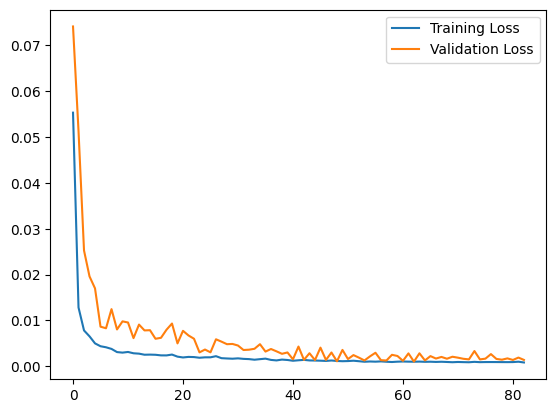

In [71]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [72]:
val_pred = model.predict(X_val)
val_pred_rescaled = scaler.inverse_transform(val_pred)
y_val_rescaled = scaler.inverse_transform(y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


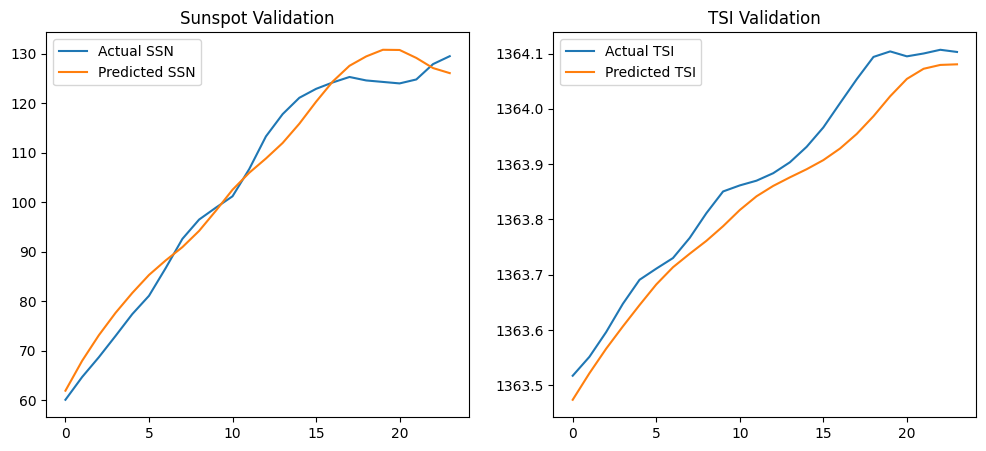

In [73]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_val_rescaled[:, 0], label='Actual SSN')
plt.plot(val_pred_rescaled[:, 0], label='Predicted SSN')
plt.title('Sunspot Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_val_rescaled[:, 1], label='Actual TSI')
plt.plot(val_pred_rescaled[:, 1], label='Predicted TSI')
plt.title('TSI Validation')
plt.legend()
plt.show()

In [74]:
current_sequence = train_data_scaled[-sequence_length:]  # Last training sequence
forecast = []
for _ in range(6 * 12):  # 72 months (6 years)
    pred = model.predict(current_sequence[np.newaxis, ...], verbose=0)[0]
    forecast.append(pred)
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1] = pred

forecast_rescaled = scaler.inverse_transform(forecast)

In [75]:
forecast_dates = pd.date_range(start='2024-01-01', periods=6*12, freq='MS')

In [76]:
# Prepare historical data
historical_dates = pd.to_datetime(merged_data[['year', 'month']].assign(day=1))
historical_ssn = merged_data['ssn'].values
historical_tsi = merged_data['tsi'].values

# Combine historical and forecast data
combined_dates = pd.concat([pd.Series(historical_dates), pd.Series(forecast_dates)])  # Convert to Series
combined_ssn = np.concatenate([historical_ssn, forecast_rescaled[:, 0]])
combined_tsi = np.concatenate([historical_tsi, forecast_rescaled[:, 1]])

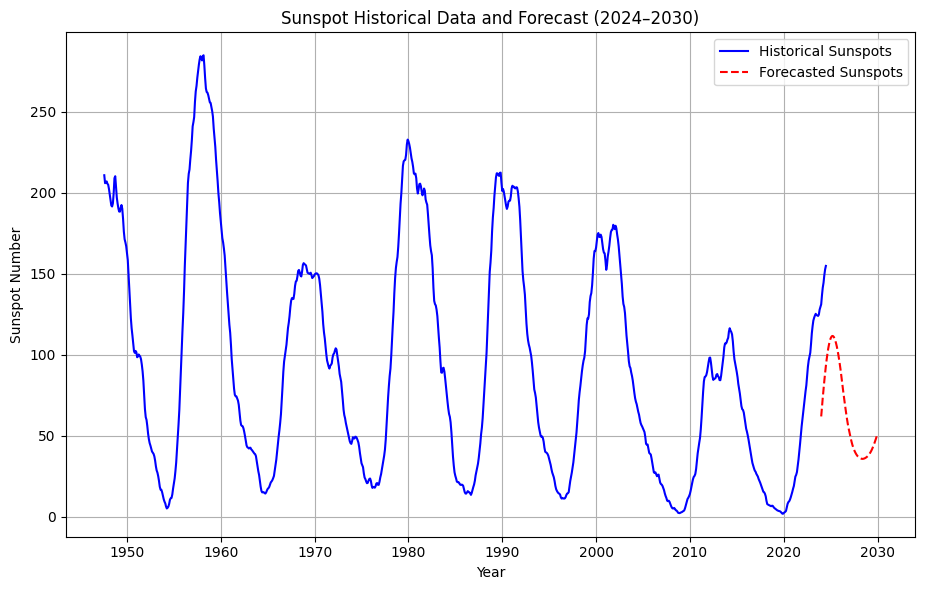

In [77]:
plt.figure(figsize=(18, 6))

# Sunspot plot
plt.subplot(1, 2, 1)
plt.plot(historical_dates, historical_ssn, label='Historical Sunspots', color='blue')
plt.plot(forecast_dates, forecast_rescaled[:, 0], label='Forecasted Sunspots', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Historical Data and Forecast (2024–2030)')
plt.legend()
plt.grid(True)

# TSI plot
# plt.subplot(1, 2, 2)
# plt.plot(historical_dates, historical_tsi, label='Historical TSI', color='green')
# plt.plot(forecast_dates, forecast_rescaled[:, 1], label='Forecasted TSI', color='orange', linestyle='--')
# plt.xlabel('Year')
# plt.ylabel('Total Solar Irradiance')
# plt.title('TSI Historical Data and Forecast (2024–2030)')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()